# 部署機器學習模型 (1/2)
首先，歡迎來到部署機器學習模型的實作範例，希望前面的環境設置都很順利!

雖然部署模型是整個機器學習生命週期的最後一個步驟，但我想大家應該都迫不及待想知道到底該怎麼做，所以還是趕緊切入正題，實際感受一下模型活起來的感覺吧😉

這裡我們會部署預先訓練好的 [`YOLOv4`](https://arxiv.org/abs/2004.10934) 模型進行物件偵測，而訓練資料為 [MS COCO 資料集](https://cocodataset.org/#home)，其中包含了 80 種日常生活物品：

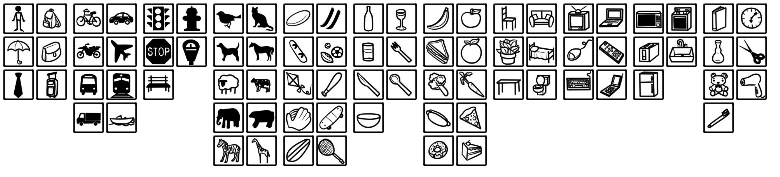

以下是我們會執行的步驟：
1. 檢視實際辨識時使用的圖片
2. 對模型進行基本認識
3. 使用 [`fastAPI`](https://fastapi.tiangolo.com/) 進行部署

## 使用 YOLOv4 進行物件偵測

### 檢視圖片
來看看實際會傳入 YOLOv4 模型的圖片，也體會一下模型可以辨識哪些日常物品。

In [1]:
from IPython.display import Image, display


Now Displaying: cat.jpg


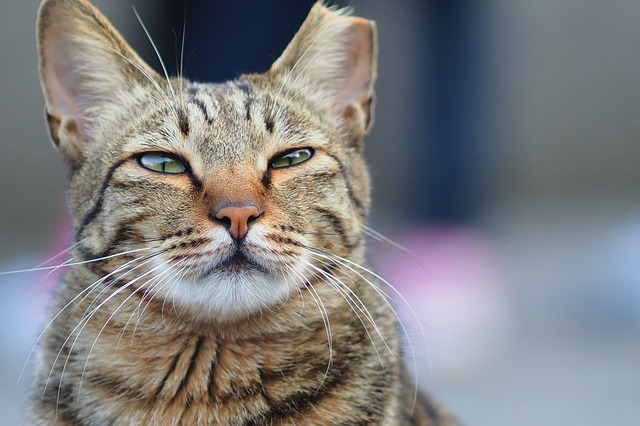


Now Displaying: pizza.jpg


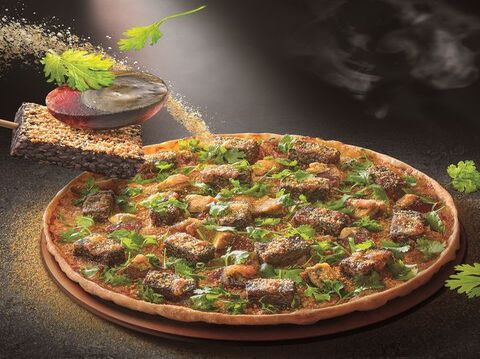


Now Displaying: car.jpg


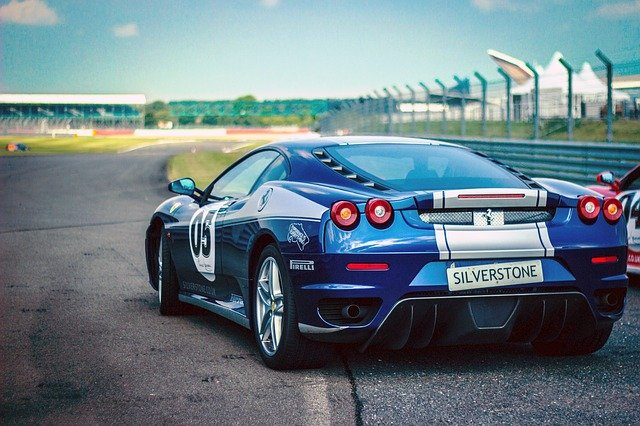


Now Displaying: girl.jpg


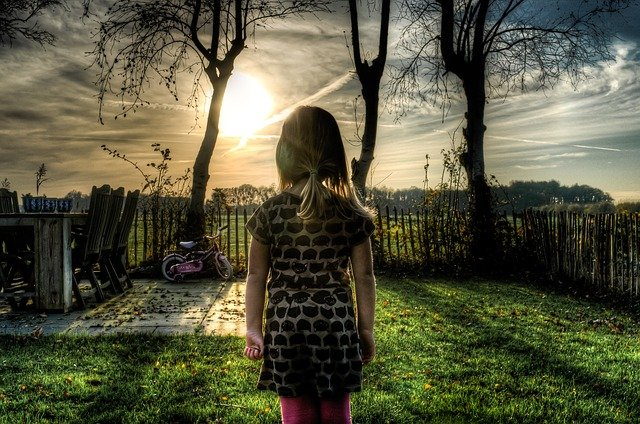

In [2]:
# Example images
images = [
    'cat.jpg',
    'pizza.jpg',
    'car.jpg',
    'girl.jpg'
]

for image in images:
    print(f"\nNow Displaying: {image}")
    display(Image(filename=f"images/{image}", width=250))

### 模型概覽
大致對圖片與要辨識的物品有個概念後，現在來看看模型能不能正確的偵測並分類它們。

因為這裡的重點是部署，所以模型的部分直接使用簡單卻強大的物件偵測函式庫 [`cvlib`](https://www.cvlib.net/)，利用其 [`detect_common_objects`](https://docs.cvlib.net/object_detection/) 函式，它會接收格式為 [`numpy array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) 的圖片並回傳：


- `bbox`：包含被偵測到物品定界框的 list。
        例如
    ```python
        [[35, 80, 124, 188], [121, 91, 230, 177]]
    ```


- `label`: 包含被偵測到物件標籤的 list。
        例如
    ```python
        ['cat', 'dog']
    ```


- `conf`:  包含被偵測到物件信心分數的 list。
        例如
    ```python
        [0.8760120272636414, 0.6513471007347107]
    ```

下一節就能看到這些回傳值實際會怎麼被使用。

### 建立 detect_and_draw_box 函式

在使用物件偵測模型之前，先建立一個資料夾讓我們能存放辨識完的結果：

In [3]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

首先來定義 `detect_and_draw_box` 函式，其輸入參數為欲辨識圖片的檔名 **filename**、模型 **model**、信心閾值 **confidence**，它會偵測圖片內的常見物件然後回傳加上定界框與其相對應類別的圖片作為結果。

而以模型作為輸入的理由為 cvlib 的 `detect_common_object` 函數預設使用 `yolov4` 模型，但也提供了需要較少運算資源的版本 `yolov4-tiny` 以及上一版的 YOLO 模型 `yolov3` 與 `yolov3-tiny`。

因此這裡可以輸入 `yolov4-tiny` 來將其設定為 `detect_and_draw_box` 的預設模型，雖然為了縮小模型的尺度犧牲了一些準確度，但它的表現依然很亮眼，且下載預訓練權重的時間也會大幅縮短。

另外，模型的輸出向量為圖片中不同物件是否存在的機率，而輸入的信心閾值 **confidence** 則可以用來控制機率大於多少才判定為存在並顯示於結果的圖片上，這裡使用和 `detect_common_object` 函數相同的預設值 0.5。

In [4]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov4-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): The detection model to be used, supported models are: yolov3, yolov3-tiny, yolov4, yolov4-tiny.
                     Defaults to "yolov4-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}', width=500))

Image processed: cat.jpg

Detected object: cat with confidence level of 0.9575682878494263



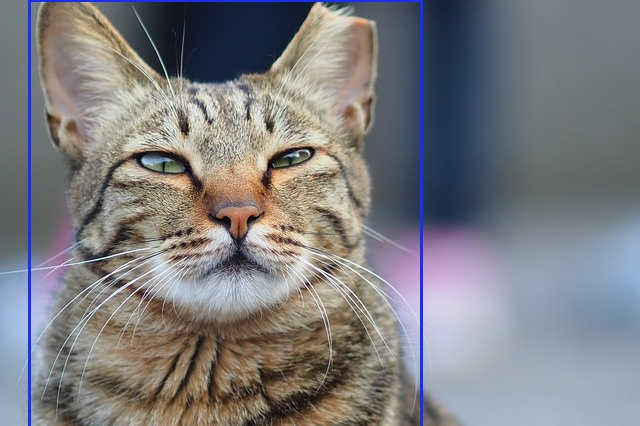

Image processed: pizza.jpg

Detected object: pizza with confidence level of 0.9716585278511047



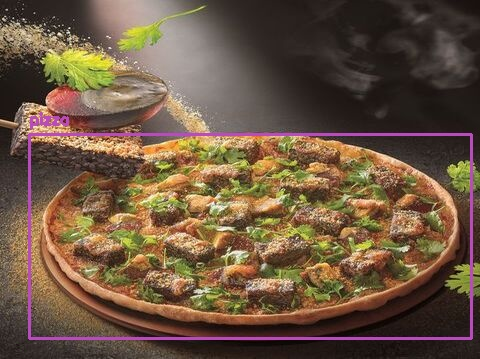

Image processed: car.jpg

Detected object: car with confidence level of 0.9986836910247803



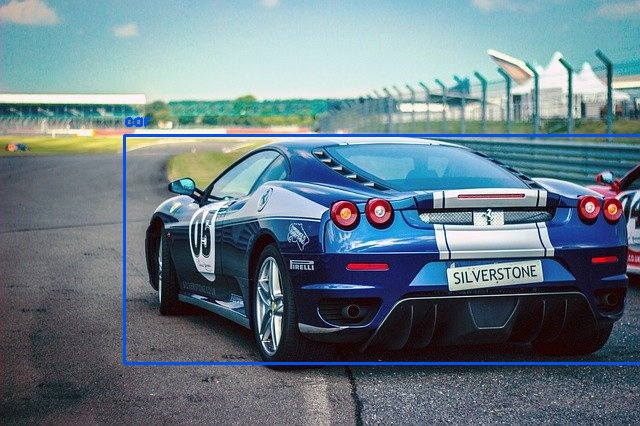

Image processed: girl.jpg

Detected object: person with confidence level of 0.9987289309501648

Detected object: bicycle with confidence level of 0.8785525560379028



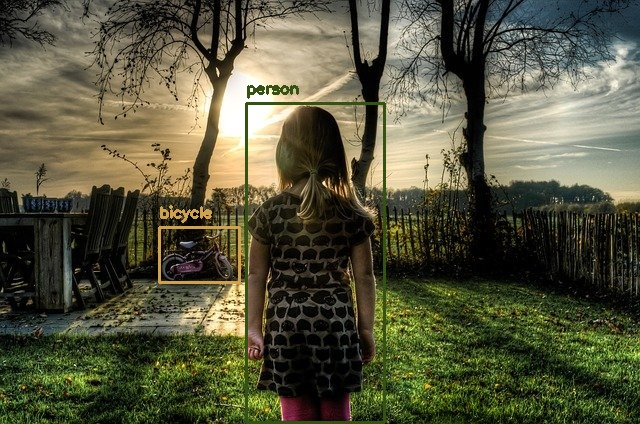

In [5]:
for image in images:
    detect_and_draw_box(image)

## Changing the confidence level

可以看到物件偵測的結果還蠻不錯的，現在來試試較困難的情況，以包含較多物件的圖片進行測試：

Image processed: taipei.jpg

Detected object: person with confidence level of 0.9858730435371399

Detected object: person with confidence level of 0.9577344059944153

Detected object: car with confidence level of 0.9555498957633972

Detected object: traffic light with confidence level of 0.9151067733764648

Detected object: person with confidence level of 0.8791032433509827

Detected object: traffic light with confidence level of 0.8132080435752869

Detected object: car with confidence level of 0.7690689563751221

Detected object: traffic light with confidence level of 0.7666055560112

Detected object: person with confidence level of 0.7654560208320618

Detected object: car with confidence level of 0.7235265374183655

Detected object: traffic light with confidence level of 0.7121425867080688

Detected object: person with confidence level of 0.6859661340713501

Detected object: person with confidence level of 0.5572274327278137

Detected object: handbag with confidence level of 0.550161

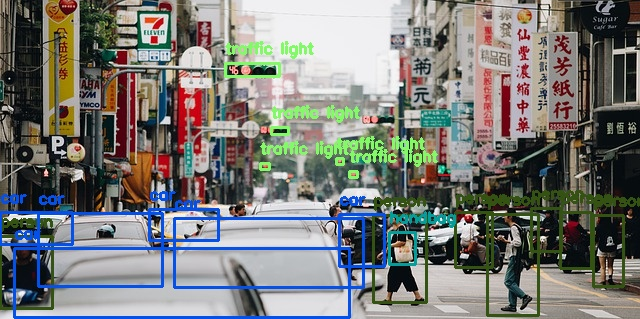

In [6]:
detect_and_draw_box("taipei.jpg")

可以看到 **模型少偵測了許多人車**，但先前確實可以偵測到單個人與車，模型應該有學到人、車長怎樣的表示法才對。

其中一個可能為，模型確實偵測到了那些人、車，但信心小於 0.5，所以可以試著降低閾值來看看這個假設是否成立：

Image processed: taipei.jpg

Detected object: person with confidence level of 0.9858730435371399

Detected object: person with confidence level of 0.9577344059944153

Detected object: car with confidence level of 0.9555498957633972

Detected object: traffic light with confidence level of 0.9151067733764648

Detected object: person with confidence level of 0.8791032433509827

Detected object: traffic light with confidence level of 0.8132080435752869

Detected object: car with confidence level of 0.7690689563751221

Detected object: traffic light with confidence level of 0.7666055560112

Detected object: person with confidence level of 0.7654560208320618

Detected object: car with confidence level of 0.7235265374183655

Detected object: traffic light with confidence level of 0.7121425867080688

Detected object: person with confidence level of 0.6859661340713501

Detected object: person with confidence level of 0.5572274327278137

Detected object: handbag with confidence level of 0.550161

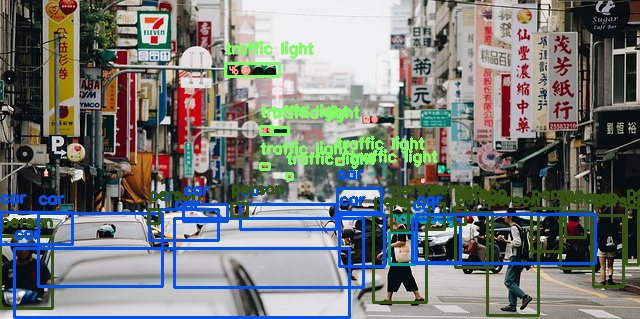

In [7]:
detect_and_draw_box("taipei.jpg", confidence=0.2)

可以看到降低信心閾值讓模型成功偵測到大部分的人、車，但為了正確偵測到圖片中的物件，我們需要將信心閾值設得很低。

一般來說，在提高、降低這類參數時都要格外小心，因為改變它們的值有可能產生非預期的結果。

## 使用 fastAPI 部署模型

### 將物件偵測模型放進伺服器

在對模型運作有基本的概念之後，我們準備進入重頭戲了，但在開始部署之前，先簡單複習一些重要的概念，以及 `fastAPI` 如何實現這些概念。

另外也建立一個資料夾來存放上傳至伺服器的圖片：

In [8]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

### 概念簡介

#### 主從式架構 (Client-Server model)
通常講到部署，實際上指的是把進行預測所需的全部軟體放進一個 **伺服器(server)** 中，如此一來，**客戶端(client)** 可以藉由將 **請求(requests)** 傳送到伺服器來與機器學習模型互動。

模型會在伺服器中等待客戶端發送的預測請求，因此請求必須包含模型進行預測所需的資訊，伺服器則會使用這些資訊來將預測回傳至客戶端。

> 通常一次 request 會包含數個預測需求。

首先，我們可以建立 `FastAPI` class 的實例 (instance)：
```python
app = FastAPI()
```
接著使用這個實例來建立負責處理預測之邏輯的接口 (endpoints)，當所有程式碼都就定位之後，只需要執行以下指令就能啟動伺服器：
```python
uvicorn.run(app)
```

我們的 API 是使用 fastAPI 編寫的，但上線 (serving) 是使用 [`uvicorn`](https://www.uvicorn.org/)，它是速度非常快的非同步伺服器閘道界面 (Asynchronous Server Gateway Interface, ASGI)，這兩樣技術會密切連接，但我們並不需要了解實作的細節，現在只需要知道 uvicorn 負責 serving 就夠了。

#### 接口 (Endpoints)
同一個伺服器可以 host 多個模型，只須為它們指派各自的接口即可隨意選用，而每個接口都是由 URL 的型式來代表。
假設我們有一個網站叫 myawesomemodel.com，若上面有三個不同的模型，它們可分別位於以下接口：
- `myawesomemodel.com/count-cars/`
- `myawesomemodel.com/count-apples/`
- `myawesomemodel.com/count-plants/`

而每個模型的功能就如其接口命名型式所示。

在 FastAPI 中，定義接口的步驟如下：
1. 撰寫一個處理該接口所有運作邏輯的函式。
2. 使用包含 HTTP method 與 URL 型式的函式 [裝飾(decorating)](https://www.python.org/dev/peps/pep-0318/) 它。

以下示範允許 HTTP GET 請求的接口 "/my-endpoint"：
```python
@app.get("/my-endpoint")
def handle_endpoint():
    ...
    ...
```

#### HTTP 請求 (HTTP Requests)
客戶端與伺服器藉由 HTTP 協定溝通，這些溝通會以動詞來標記它們的實際行動，其中兩個最常見的動詞為：

- `GET`：由伺服器取回資訊，如果客戶端對伺服器的某接口提出了 `GET` 請求，我們可以在不須提供額外資訊的情況下，由此接口得到一些資訊。
- `POST`：提供需要做反應的資訊給伺服器，如果提出 `POST` 請求就代表明確的告訴伺服器我們會提供某些資訊，而它必須以某種方式處理這些資訊。

通常都是以 `POST` 請求來與位於某接口的機器學習模型互動，因為我們需要提供資訊給它進行預測。

以下示範允許 HTTP POST 請求的接口 "/my-other-endpoint"：
```python
@app.post("/my-other-endpoint")
def handle_other_endpoint(param1: int, param2: str):
    ...
    ...
```
其中，允許POST 請求的 handler 函式會包含參數，因為它預期客戶提供某些資訊。

好啦，以上就是所有會用的基本知識，開始進入正題吧！！

In [9]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException, Query
from fastapi.responses import StreamingResponse

In [10]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='使用 FastAPI 部署機器學習模型!!')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"
    yolov4tiny = "yolov4-tiny"
    yolov4 = "yolov4"

# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/", tags=["確認 API 是否成功運行"])
def home():
    return "恭喜! 你的 API 成功運行中，去 http://localhost:8000/docs 看看吧!"


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict", tags=["進行預測"]) 
def prediction(model: Model, confidence: float = Query(0.5, ge=0, le=1.0), file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model, confidence=confidence)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

執行下面的 cell 就能將伺服器上線了。

但這會使 notebook 在我們手動中止 kernel 前無法執行其它 cell，可以點選 Kernel → Interrupt Kernel，或先使用 `ESC` 進入 command 模式再連點兩次 `I` 即可中止 kernel。

In [11]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"
 
# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [8132]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:5100 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:5100 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:5104 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:5104 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:5150 - "GET /predict?model=yolov4-tiny&confidence=0.2 HTTP/1.1" 405 Method Not Allowed
INFO:     127.0.0.1:5150 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:5151 - "GET /predict HTTP/1.1" 405 Method Not Allowed
INFO:     127.0.0.1:5157 - "GET /predict?model=yolov4-tiny&confidence=0.2 HTTP/1.1" 405 Method Not Allowed
INFO:     127.0.0.1:5166 - "POST /predict?model=yolov4-tiny&confidence=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:5168 - "POST /predict?model=yolov4-tiny&confidence=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:5170 - "POST /predict?model=yolov4-tiny&confidence=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:5172 - "POST /predict?model=yolov4-tiny&confidence=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:5175 - "GET /pred

RuntimeError: Event loop stopped before Future completed.

伺服器已經上線了，可以到 http://localhost:8000/ 看看它是否成功運作，若成功運作應該可以看到以下畫面：

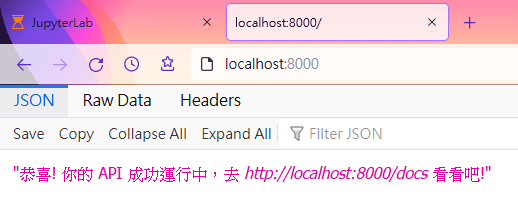

藉由訪問 http://localhost:8000/docs 可以進入 fastAPI 提供的內建 client，試試上傳圖片來看看我們的 API 如何偵測圖中的物件並回傳加上定界框與類別的圖片吧。

其介面如下，點擊 `/predict` 接口可以開啟更多選項，接著點擊 **Try it out** 就可以開始測試 API 了：
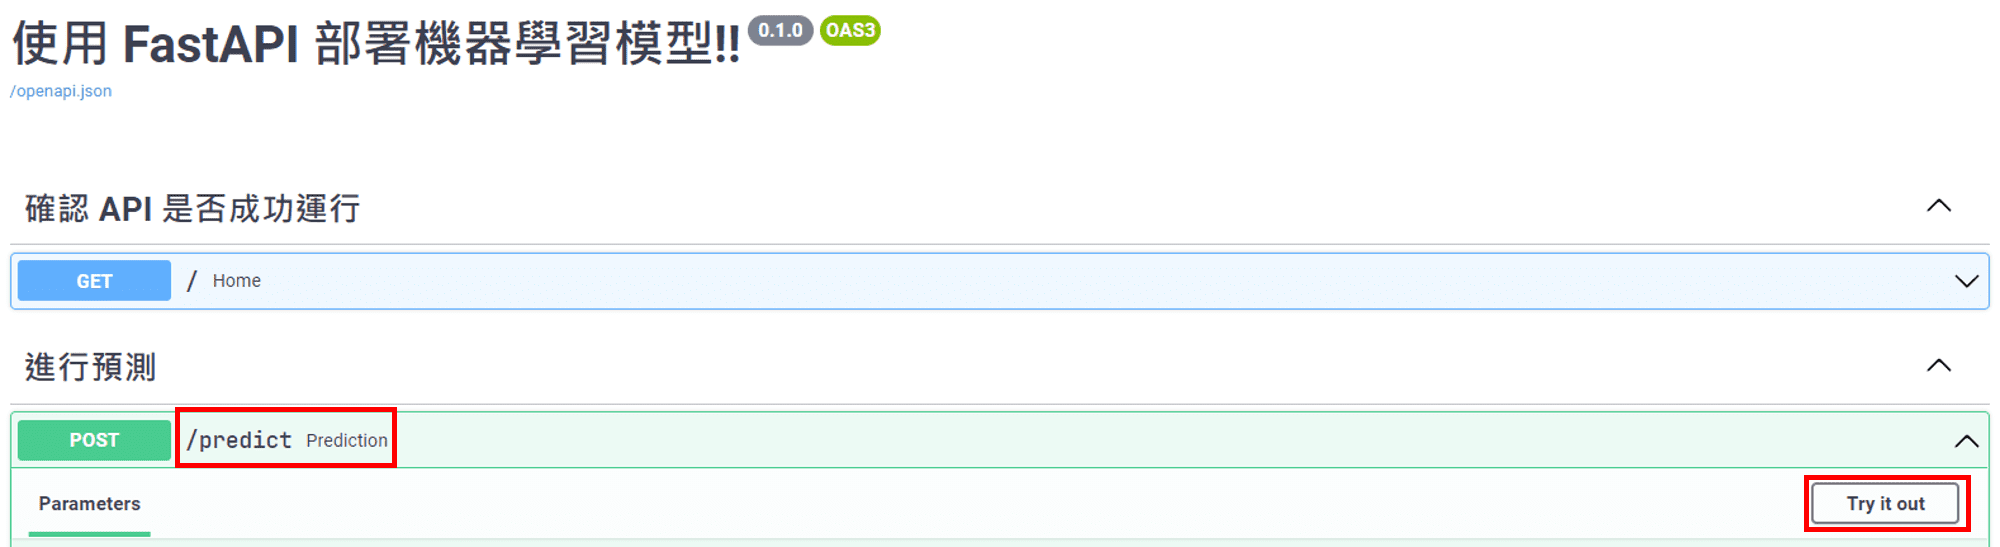

可以在 **model** 欄位選取要使用的模型 (注意若選用 YOLO 模型需要等待一段時間讓權重下載完)。

點擊 **file** 欄位的 **選擇檔案** 則可以上傳想要進行辨識的圖片，最後點擊藍色 Execute 即可發送 HTTP 請求至伺服器，最後往下滑就可以看到辨識的結果了。

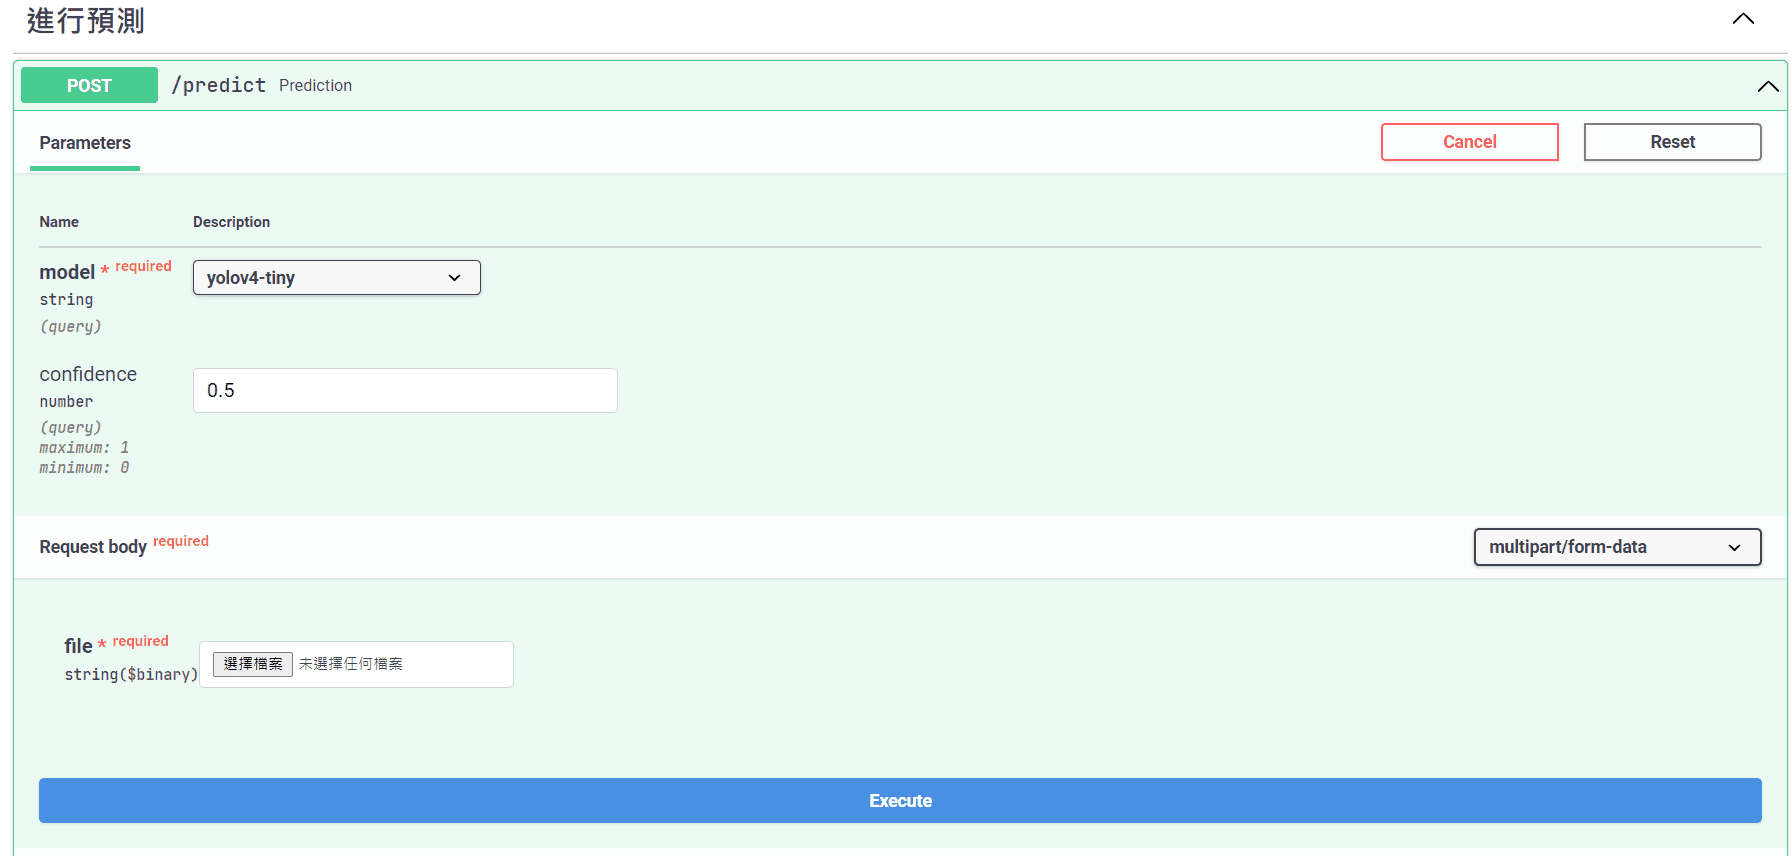

可以試試各種不同的圖片與信心閾值，當模型漏掉某些物件時可以試著降低閾值。

### 由另一個 Client 使用模型

fastAPI 讓我們可以使用內建的 client 與 API 互動固然很棒，但其實我們也可以不使用 UI，直接用程式碼與其互動。

請保持伺服器執行，然後在另一個分頁打開 `client.ipynb` 筆記本吧。

> 記得到 View 確認 Simple  Interface 是否被打開，如果有請關掉，以免無法開啟另一個分頁。